# Predicting the Genre of Books from Summaries

## Loading all the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/cisitu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/cisitu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Preparation

In this analysis, a set of book summaries from [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) is used. The dataset contains a large number of summaries and include the genre information of the books taken from Freebase. Each book can have more than one genre and there are 227 genres listed in total. In order to simplify the problem, only a small number of target genres that occur frequently are selected and the experiment only uses the book with selected genre.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/Portfolio3files/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape

(8954, 5)

In [4]:
books_distribution_df = genre_books.groupby('genre').count()
display(books_distribution_df)

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


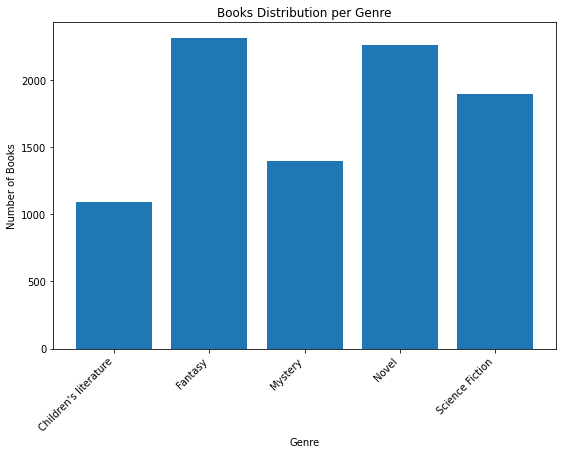

In [5]:
plt.figure(figsize=(9, 6))
plt.title('Books Distribution per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, horizontalalignment='right')
plt.bar(books_distribution_df.index, books_distribution_df['title'])
plt.show()

From the bar chart, it is revealed that the class of the dataset is not too uniformly distributed. The bar chart shows fantasy is the most common genre in the dataset, followed by novel. On the other hand, books with children's literatures genre are the least common.

## Create and Measure the Models Accuracy

### TF-IDF with default parameter

The first stage of the this experiment is to get the summary of each book from dataset and transform it using TF-IDF method. The transformation is needed because the models cannot get raw text as input. All of the models in this stage use TF-IDF transformed text with default parameter as input.  

In [6]:
# define function to stem sentence
porter=PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# stem book summary
genre_books['text_stemmed'] = genre_books.summary.apply(stemSentence)

In [7]:
# Splitting the dataset into train data and test data
X_train, X_test, y_train, y_test = train_test_split(genre_books.drop(['genre'], axis=1), genre_books.loc[:,'genre'], random_state=69,test_size=0.2)

In [8]:
y_test[y_test == "Children's literature"]

5143     Children's literature
9826     Children's literature
11164    Children's literature
8682     Children's literature
924      Children's literature
                 ...          
13820    Children's literature
1957     Children's literature
13090    Children's literature
4232     Children's literature
13284    Children's literature
Name: genre, Length: 218, dtype: object

In [9]:
# Transform the train data and test data using tfidf
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train.summary)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test.summary)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [10]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
predicted = clf.predict(X_test_tfidf)

print('The Multinomial Naive Bayes Model accuracy score is %.2f, the confusion matrix is below \n' %(accuracy_score(predicted, y_test)))
print(confusion_matrix(predicted, y_test))

logisticRegression = LogisticRegression(max_iter=200).fit(X_train_tfidf, y_train)
LR_predicted = logisticRegression.predict(X_test_tfidf)

print('\nThe Logistic Regresion Model accuracy score is %.2f, the confusion matrix is below \n' %(accuracy_score(LR_predicted, y_test)))
print(confusion_matrix(LR_predicted, y_test))

KNNclassifier = KNeighborsClassifier(n_neighbors=10).fit(X_train_tfidf, y_train)
KNN_predicted = KNNclassifier.predict(X_test_tfidf)

print('\nThe KNN Model accuracy score is %.2f, the confusion matrix is below \n' %(accuracy_score(KNN_predicted, y_test)))
print(confusion_matrix(KNN_predicted, y_test))

The Multinomial Naive Bayes Model accuracy score is 0.56, the confusion matrix is below 

[[  0   0   0   0   0]
 [ 95 401  52  45 101]
 [  0   1  27   0   2]
 [123  47 197 389  77]
 [  0  18   2  21 193]]

The Logistic Regresion Model accuracy score is 0.71, the confusion matrix is below 

[[ 90  11  10   5   5]
 [ 45 362  18  27  50]
 [ 10   7 186  17   9]
 [ 69  43  57 363  45]
 [  4  44   7  43 264]]

The KNN Model accuracy score is 0.52, the confusion matrix is below 

[[ 66  16  18  24  11]
 [ 28 224  20  30  42]
 [  4   3 134  13   5]
 [100 179  93 345 146]
 [ 20  45  13  43 169]]


Three type of models are used in the first stage are Multinomial Naive Bayes, Logistic Regression and KNN. All of the models use TF-IDF transformed book summary with default parameter as input. The model with highest accuracy is Logistic Regression with accuracy score 0.71, followed by Multinomial Naive Bayes with score 0.56. The confusion matrix of Multinomial Naive Bayes shows interesting result regarding the predicted class. All of the elements in first row is 0 and it means the model never predicts the output to be class 1 which is Children's literature genre. 

### TF-IDF with Stop Words Parameter Enabled

After the models training and measuring accuracy of the models in stage 1, the experiment continues with different treatment in CountVectorizer TF-IDF parameter. This time stop_words parameter is enabled and the training and measuring in stage 1 are repeated. The parameter enabling is expected to improve the accuracy of the three models because it removes common English words that are frequently used in a sentence, such as "the", and don't really give any meaningful input to the models. 

In [11]:
# Transform the train data and test data using tfidf

count_vect = CountVectorizer(stop_words='english')
tfidf_transformer = TfidfTransformer()                 

X_train_counts_stop = count_vect.fit_transform(X_train.summary)
X_train_tfidf_stop = tfidf_transformer.fit_transform(X_train_counts_stop)

X_test_counts_stop = count_vect.transform(X_test.summary)
X_test_tfidf_stop = tfidf_transformer.transform(X_test_counts_stop)

In [12]:
clf = MultinomialNB().fit(X_train_tfidf_stop, y_train)
predicted = clf.predict(X_test_tfidf_stop)

print('The Multinomial Naive Bayes Model using stop words accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(predicted, y_test)))
print(confusion_matrix(predicted, y_test))

logisticRegression = LogisticRegression(max_iter=200).fit(X_train_tfidf_stop, y_train)
LR_predicted_stop = logisticRegression.predict(X_test_tfidf_stop)

print('\nThe Logistic Regression Model using stop words accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(LR_predicted_stop, y_test)))
print(confusion_matrix(LR_predicted_stop, y_test))

KNNclassifier_stop = KNeighborsClassifier(n_neighbors=10).fit(X_train_tfidf_stop, y_train)
KNN_predicted_stop = KNNclassifier_stop.predict(X_test_tfidf_stop)

print('\nThe KNN Model using stop words accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(KNN_predicted_stop, y_test)))
print(confusion_matrix(KNN_predicted_stop, y_test))

The Multinomial Naive Bayes Model using stop words accuracy score is 0.60 and the confusion matrix is below 

[[  0   0   0   0   0]
 [ 87 382  37  31  68]
 [  0   1  70   1   3]
 [131  58 167 390  73]
 [  0  26   4  33 229]]

The Logistic Regression Model using stop words accuracy score is 0.71 and the confusion matrix is below 

[[ 92  11  13   8   5]
 [ 44 368  16  25  48]
 [  8   8 187  17  11]
 [ 70  39  56 361  46]
 [  4  41   6  44 263]]

The KNN Model using stop words accuracy score is 0.56 and the confusion matrix is below 

[[ 98  48  32  68  25]
 [ 39 302  30  63  62]
 [ 17  22 162  50  25]
 [ 54  55  45 221  37]
 [ 10  40   9  53 224]]


The second stage transforms book summary with parameter English stop words enabled. Similar to the first stage, Logistic Regression has the highest accuracy score with 0.71, followed by Multinomial Naive Bayes with 0.60 and KNN with 0.56. Multinomial Naive Bayes accuracy increases from 0.56 to 0.60 and KNN accuracy also increases from 0.52 to 0.56. Unusual result of Multinomial Naive Bayes confusion matrix also happens in stage 2. All of the first row elements are 0 and this means Multinomial Naive Bayes never predicts the output to be children's literature genre.

### TF-IDF using Stemmed Text as Input
In the first 2 stages, input text doesn't get any treatment or transformation before CountVectorizer and TF-IDF transformation. This stage transform the input text using Stem technique. The datacamp says "[Stemming](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python) is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language". Transforming word into their stemmed version might be able to increase the performance of classification model because words that are different because of grammar's inflection are treated and categorised into the same word. For example, words like 'trouble', 'troubling', 'troubled' are transformed into 'troubl'. 

In [13]:
# Stem text example
X_train.text_stemmed.iloc[200]

"the book start where exil left off , with ben return to jacen aboard the sith medit sphere he found on ziost . the novel follow jacen as he manipul polit , introduc a new law that allow him to rewrit other law . use thi and cal oma ' betray to the galact allianc as leverag , he and admir niathal stage a bloodless coup , arrest oma and instal themselv as joint chief of state . at the same time , jacen send ben to assassin dur gejjen , throw the corellian-l confeder into chao . meanwhil , boba fett and mirta gev are still in search of a cure to fett 's ill after find kad skirata , the son of a clone . in exchang for the promis of make the mandalorian a unit peopl , he cure boba , give him anoth thirti or so year to live . ben overhear a convers between lumiya and jacen and , horrifi , confess all to hi mother , mara jade skywalk . mara , livid with jacen for attempt to turn ben to the dark side , set out to kill him . thi backfir , howev , as jacen kill mara as hi final sacrific . thi s

In [14]:
# Transform the train data and test data using tfidf
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts_stem = count_vect.fit_transform(X_train.text_stemmed)
X_train_tfidf_stem = tfidf_transformer.fit_transform(X_train_counts_stem)

X_test_counts_stem = count_vect.transform(X_test.text_stemmed)
X_test_tfidf_stem = tfidf_transformer.transform(X_test_counts_stem)

In [15]:
clf = MultinomialNB().fit(X_train_tfidf_stem, y_train)
predicted = clf.predict(X_test_tfidf_stem)

print('The Multinomial Naive Bayes Model using stemmed input accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(predicted, y_test)))
print(confusion_matrix(predicted, y_test))

logisticRegression = LogisticRegression(max_iter=200).fit(X_train_tfidf, y_train)
LR_predicted = logisticRegression.predict(X_test_tfidf)

print('\nThe Logistic Regresion Model using stemmed input accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(LR_predicted, y_test)))
print(confusion_matrix(LR_predicted, y_test))

KNNclassifier = KNeighborsClassifier(n_neighbors=10).fit(X_train_tfidf, y_train)
KNN_predicted = KNNclassifier.predict(X_test_tfidf)

print('\nThe KNN Model using stemmed input accuracy score is %.2f and the confusion matrix is below \n' %(accuracy_score(KNN_predicted, y_test)))
print(confusion_matrix(KNN_predicted, y_test))

The Multinomial Naive Bayes Model using stemmed input accuracy score is 0.56 and the confusion matrix is below 

[[  0   0   0   0   0]
 [ 89 390  52  34  87]
 [  0   1  25   0   2]
 [129  56 199 397  92]
 [  0  20   2  24 192]]

The Logistic Regresion Model using stemmed input accuracy score is 0.71 and the confusion matrix is below 

[[ 90  11  10   5   5]
 [ 45 362  18  27  50]
 [ 10   7 186  17   9]
 [ 69  43  57 363  45]
 [  4  44   7  43 264]]

The KNN Model using stemmed input accuracy score is 0.52 and the confusion matrix is below 

[[ 66  16  18  24  11]
 [ 28 224  20  30  42]
 [  4   3 134  13   5]
 [100 179  93 345 146]
 [ 20  45  13  43 169]]


The last stage used stem transformed text as input and the model with highest accuracy is Logistic Regression, followed by Multinomial Bayes Analysis and KNN. Multinomial Bayes Analysis still has peculiar confusion matrix that shows the model never predicts output to be class 1 or children's literature genre.

## Conclusion

This project shows that Logistic Regression Model is the best classifying model if the input is text based input. The accuracy score of Logistic Regression Model is consistently around 0.71 in all three different treatment of inputs. The three different treatments are transforming text using TF-IDF with default parameter, transforming text using TF-IDF with English stop words parameter enabled and transforming stemmed text using TF-IDF with default parameter. The best scores all achieved by all of three models when TF-IDF transform with English stop words enabled is used.